In [1]:
!pip install sentencepiece
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import tensorflow as tf
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")
# https://wikidocs.net/44249 

train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
# 노이제 제거 
#(1) 문장부호
def pad_punctuation(sentence, punc):
    for p in punc:
        sentence = sentence.replace(p, " " + p + " ")

    return sentence

sentence = "Hi, my name is john."

print(pad_punctuation(sentence, [".", "?", "!", ","]))

Hi ,  my name is john . 


In [3]:
# 노이즈 제거 연습 - 노드 그대로
# From The Project Gutenberg
# (https://www.gutenberg.org/files/2397/2397-h/2397-h.htm)

corpus = \
"""
In the days that followed I learned to spell in this uncomprehending way a great many words, among them pin, hat, cup and a few verbs like sit, stand and walk. 
But my teacher had been with me several weeks before I understood that everything has a name.
One day, we walked down the path to the well-house, attracted by the fragrance of the honeysuckle with which it was covered. 
Some one was drawing water and my teacher placed my hand under the spout. 
As the cool stream gushed over one hand she spelled into the other the word water, first slowly, then rapidly. 
I stood still, my whole attention fixed upon the motions of her fingers. 
Suddenly I felt a misty consciousness as of something forgotten—a thrill of returning thought; and somehow the mystery of language was revealed to me. 
I knew then that "w-a-t-e-r" meant the wonderful cool something that was flowing over my hand. 
That living word awakened my soul, gave it light, hope, joy, set it free! 
There were barriers still, it is true, but barriers that could in time be swept away.
""" 

def cleaning_text(text, punc, regex):
    # 노이즈 유형 (1) 문장부호 공백추가
    for p in punc:
        text = text.replace(p, " " + p + " ")

    # 노이즈 유형 (2), (3) 소문자화 및 특수문자 제거
    text = re.sub(regex, " ", text).lower()

    return text

print(cleaning_text(corpus, [".", ",", "!", "?"], "([^a-zA-Z0-9.,?!\n])"))


in the days that followed i learned to spell in this uncomprehending way a great many words ,  among them pin ,  hat ,  cup and a few verbs like sit ,  stand and walk .  
but my teacher had been with me several weeks before i understood that everything has a name . 
one day ,  we walked down the path to the well house ,  attracted by the fragrance of the honeysuckle with which it was covered .  
some one was drawing water and my teacher placed my hand under the spout .  
as the cool stream gushed over one hand she spelled into the other the word water ,  first slowly ,  then rapidly .  
i stood still ,  my whole attention fixed upon the motions of her fingers .  
suddenly i felt a misty consciousness as of something forgotten a thrill of returning thought  and somehow the mystery of language was revealed to me .  
i knew then that  w a t e r  meant the wonderful cool something that was flowing over my hand .  
that living word awakened my soul ,  gave it light ,  hope ,  joy ,  set it

In [4]:
data = list(train_data['document']) + list(test_data['document'])

# list(set(document_train))  + list(set(document_test))
print("Data Size:", len(data))
# 전처리1 중복 제거
train_data = train_data.drop_duplicates(subset=['document'])
train_data = train_data.dropna(how = 'any') 
test_data = test_data.drop_duplicates(subset=['document'])
test_data = test_data.dropna(how = 'any') 

Data Size: 200000


In [5]:
train_data.drop_duplicates().reset_index(drop=True)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
146177,6222902,인간이 문제지.. 소는 뭔죄인가..,0
146178,8549745,평점이 너무 낮아서...,1
146179,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
146180,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [6]:
test_data.drop_duplicates().reset_index(drop=True)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49152,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49153,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49154,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49155,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [7]:
'''
document_train = list(train_data['document'])
label_train = list(train_data['label'])

document_test = list(test_data['document'])
label_test = list(test_data['label'])


print("Train Data Size:", len(document_train))
print("Test Data Size:", len(document_test))
'''

'\ndocument_train = list(train_data[\'document\'])\nlabel_train = list(train_data[\'label\'])\n\ndocument_test = list(test_data[\'document\'])\nlabel_test = list(test_data[\'label\'])\n\n\nprint("Train Data Size:", len(document_train))\nprint("Test Data Size:", len(document_test))\n'

In [8]:
# 
'''
document_train = list(set(document_train)) 
label_train = list(set(label_train)) 

document_test = list(set(document_test))
label_test = list(set(label_test)) 
'''

'\ndocument_train = list(set(document_train)) \nlabel_train = list(set(label_train)) \n\ndocument_test = list(set(document_test))\nlabel_test = list(set(label_test)) \n'

Data Size: 194543
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 36


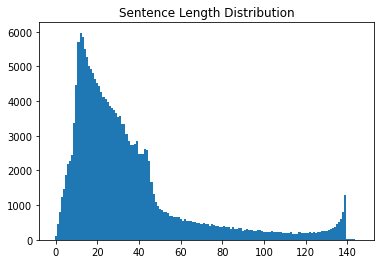

In [9]:
### 인터넷 참고해서 작성 (처음에는 document_train 따로, document_test 따로 진행하려했음)
min_len = 999
max_len = 0
sum_len = 0
data = list(train_data['document']) + list(test_data['document'])


cleaned_corpus = list(set(data))
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus: 
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

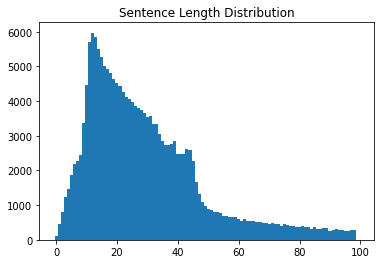

In [10]:
max_len = 100
min_len = 1

# 길이 조건에 맞는 문장만 선택
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려보자 
# 아래 나온 그래프는 최종 데이터 분포
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [12]:
'''
# Train data 문장 길이 그래프 및 예시
min_len = 999
max_len = 0
sum_len = 0

for sen in document_train: 
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train_s))

sentence_length = np.zeros((max_len), dtype=int)

for sen in document_train:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

document_train[:15]
'''

'\n# Train data 문장 길이 그래프 및 예시\nmin_len = 999\nmax_len = 0\nsum_len = 0\n\nfor sen in document_train: \n    length = len(sen)\n    if min_len > length: min_len = length\n    if max_len < length: max_len = length\n    sum_len += length\n\nprint("문장의 최단 길이:", min_len)\nprint("문장의 최장 길이:", max_len)\nprint("문장의 평균 길이:", sum_len // len(train_s))\n\nsentence_length = np.zeros((max_len), dtype=int)\n\nfor sen in document_train:\n    sentence_length[len(sen)-1] += 1\n\nplt.bar(range(max_len), sentence_length, width=1.0)\nplt.title("Sentence Length Distribution")\nplt.show()\n\ndocument_train[:15]\n'

In [13]:
'''
# Test data 문장 길이 그래프 및 예시
min_len = 999
max_len = 0
sum_len = 0

for sen in document_test: 
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(test_s))

sentence_length = np.zeros((max_len), dtype=int)

for sen in document_test:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

document_test[:15]
'''

'\n# Test data 문장 길이 그래프 및 예시\nmin_len = 999\nmax_len = 0\nsum_len = 0\n\nfor sen in document_test: \n    length = len(sen)\n    if min_len > length: min_len = length\n    if max_len < length: max_len = length\n    sum_len += length\n\nprint("문장의 최단 길이:", min_len)\nprint("문장의 최장 길이:", max_len)\nprint("문장의 평균 길이:", sum_len // len(test_s))\n\nsentence_length = np.zeros((max_len), dtype=int)\n\nfor sen in document_test:\n    sentence_length[len(sen)-1] += 1\n\nplt.bar(range(max_len), sentence_length, width=1.0)\nplt.title("Sentence Length Distribution")\nplt.show()\n\ndocument_test[:15]\n'

In [14]:

# 전처리2 - 길이 이상한 것 확인
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(data, 146)


"스폰으로 먹고사는 방송이라 어쩔수 없다고 하지만. 이건 그냥 비현실적인 자동차만;...독일3사&슈퍼카 홍보 프로그램도 아니구.대중적인 자동차 방송으로 이루어 졌으면 합니다. 보는내내 ""카탈로그 책자""를 ""동영상으로 보여주는 방송"" 같아서 씁쓸하네요.!"
"""니 짓은 생각않고, 웬 복수!""의 교훈이라! 그럼 ""서바이벌 액션""으로 홍보하면 안되지! 초반 45분은 멋지게 열더니.. 억지 반전, 하드고어로 시간끌다가, 허둥지둥 화해로 끝내버리네. 90분 러닝타임에 엔딩자막만 11분 틀어주는 해괴망측한 영화~!"
"2007.02.25_ 벌교의 한 국밥집_ 점심: ""갸는 첫째고, 저 놈은 우리 둘째~"" 재문: ""아줌마! 미안해~ 그냥.. 아줌마! 나 그 남방 잘 어울려ㅠ_ㅠ?"" 대식에게 복수하려던 1주일 전_ 대식의 엄마를 먼저 만났다. 사랑의 꽃남방도..^-^o"


In [15]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 6
Outlier Index: 7
Outlier Index: 8
Outlier Index: 9
Outlier Index: 10
Outlier Index: 11
Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15
Outlier Index: 16
Outlier Index: 17
Outlier Index: 18
Outlier Index: 19
Outlier Index: 20
Outlier Index: 21
Outlier Index: 22
Outlier Index: 23
Outlier Index: 24
Outlier Index: 25
Outlier Index: 26
Outlier Index: 27
Outlier Index: 28
Outlier Index: 29
Outlier Index: 30
Outlier Index: 31
Outlier Index: 32
Outlier Index: 33
Outlier Index: 34
Outlier Index: 35
Outlier Index: 36
Outlier Index: 37
Outlier Index: 38
Outlier Index: 39
Outlier Index: 40
Outlier Index: 41
Outlier Index: 42
Outlier Index: 43
Outlier Index: 44
Outlier Index: 45
Outlier Index: 46
Outlier Index: 47


Data Size: 194543
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 36


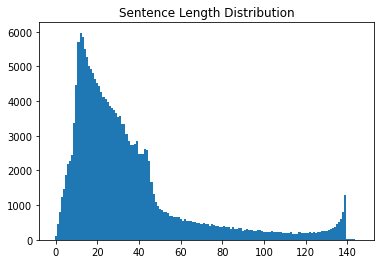

In [16]:
min_len= 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(data))  # set를 사용해서 중복을 제거
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [17]:
check_sentence_with_length(data, 1)
check_sentence_with_length(data, 2)
check_sentence_with_length(data, 3)

아
잼
1
4
굿
짱
휴
.
음
?
ㅎ
ㅋ
즐
♥
굳
네
ㅇ
k
ㅠ
쒯
♬
토
O
똥
z
헐
삼
꽝
!
풉
ㅅ
왜
ㄴ
쉣
봐
뿌
ㅜ
♡
ㅁ
0
ㅉ
d
흥
乃
찜
귯
린
시
ㅗ
a
c
흠
웅
ㅣ
오
9
쩜
애
헝
쨩
f
움
ㄳ
업
헉
군
b
;
g
올
걍
허
-
쀍
로
ㄹ
ㅂ
갑
즛
킥
함
진
ㅡ
잠
곧
ㅍ
h
·
캬
ㅆ
,
풋
ㄱ
파
ㄷ
웩
꺅
욜
ㅄ
2
핡
최고
졸작
대박
버려
망함
굳굳
안습
망작
ㅇㅇ
쵝오
굿!
별루
씐나
쓰렉
볼만
허접
비추
좋다
ㅎㅎ
아나
ㅉㅉ
야.
역시
^^
오오
평이
지루
오욈
ㅋㅋ
지송
별로
눈물
당연
쩔어
별노
몰입
졸잼
돋네
오글
이응
첨봄
최악
잼씀
ok
유후
감동
gg
;;
조앙
1점
표절
명작
으휴
에효
ㄱ굿
굿잡
잼나
10
ㅜㅜ
우왕
거지
굿굿
좋음
실망
굿.
애이
짱임
전설
mm
와우
등록
하위
그닥
뭉클
삼류
HN
윤하
섹시
실화
머냐
수작
꿀잼
동감
dd
굳ㅋ
굳!
추천
좋아
55
안봐
개쩜
올레
난해
ㅠㅠ
뭐니
ㅁㅁ
뭥미
쓰랙
좇~
오우
미안
좋구나
10점
처ㅝ주
솔직히
4대강
재밌다
재밌군
좋았다
재미무
보지마
볼만함
b b
dsa
웃스!
♥♥♥
재밋네
최고다
재밌음
쓰래기
갑이다
료코짱
2빠닼
만세-
OOO
ㅋㅋㅋ
아하!
재및음
좋아여
재미쪙
대박!
에혀~
3.6
가보자
bad
신선함
와우!
즐ㄹㅋ
좋아요
아ㅅㅂ
쨩이야
굿~!
ㅉㅉㅉ
재밋다
지못미
나이스
오짱!
전형적
원주율
좋은테
2.6
굿!!
1등?
보세요
잼없다
다섯개
접어라
쓰중쓰
좋다.
음..
좋군.
싸우자
멋져.
...
직인다
짱짱짱
별로임
진리임
감동적
최고!
재밌어
걍 굿
아시바
최고~
팬이다
별로다
좋다,
잼있다
최고.
감동!
잠온다
의리!
별로~
즐..
썩었내
짱멋짐
ㄴㄹㄴ
성룡짱
꿀잼♥
쵝오!
괜찮네
막장.
억지.
김서울
철규찡
무셔움
지겨워
꼭보셈
쓰레기
그다지
훌륭함
최고임


In [18]:
check_sentence_with_length(data, 13)

진정 위대한 영화 최고임
성룡영화중 최악인듯 ㅋㅋ
클라라볼라고화신본거아닌데
오랜만에 재밋는영화봤네요
단순한 싸이코물을 벗어난
이적의 소설. 재미없다.
영화 재미있드만.. ㅎㅎ
이게 2편이 나왔어???
영상이 너무나도 멋지다.
돈과 시간이 아까운 영화
노땅들의 한심한 추억미화
내코끼리내놔가 더재밌음ㅋ
안타까울뿐. 안타까울뿐.
'드릴브라' 에서 뿜었다
청춘에는 마침표가 없다.
말그대로 뚝방에서 볼영화
효과음이 기가막혔던 영화
욕망이라는 이름의 전차.
무슨 생각으로 만든걸까.
내 인생 최고의 미드!!
파란색 슬픔이 영화에..
ufo를 믿으려는 자들.
주성치 영화 최고의 졸작
이것도 재밌는데...ㅋㅋ
김윤진 좋아하니깐...♡
캬.. 개안음..ㅎㅎㅎㅎ
유치하지만 가볍게 볼만함
넘 재밌었어요/ㅅ/ㅎㅎㅎ
연 기 굿 화이팅해요누나
가슴이 뭉클.. 아름답딘
걍 ㅆㄹㄱ 이게 드라마?
제일 실망스런 일본 영화
이정도면 10점 받아야지
존나 재미없어요 보지마요
나름 그냥 그저그런 영화
내 생애 최악의 한국영화
이야~ 알바 많이 풀었네
강철중 시리즈 완전 잼남
감독 자질 문제라고 밖엔
룸싸롱 찌라시 같은 영화
재미없고 너무 내용이에바
억지 짜집기 스토리 구성
시간가는줄모르고 봤다..
꿀잼 근데 아나킨은 언제
뭔 버러지 같은 영화냐?
누가 이영화를 논하는가?
볼 만하지만 걸작은 아님
산만해서 못봐주겠는 영화
흠... 이해하기 힘들다
처음 부터 끝까지 좋았다
엘리자베스 넘 이뻐 ^^
피해자인척 하지마라 일본
희망은 좋은 것이여...
잔잔한 감동과 함께...
언디스퓨티드 이후로 최고
정신이상자들이 공감할려나
정식개봉을 했다는 건가?
쏘우. 여기까진 괜찮았음
후속작 영환가 뭐지 이건
본 영화들 중 가장...
4.44 프로젝트 ㅋㅋㅋ
이거 뭐지? 이거 영화?
어색한 연기 어쩔거야..
저 포스터가 인상깊었다예
최최최최악악악악 !!!!
더럽다 이게 영화냐???
사랑과 전쟁 비디오 버전
이것도 진짜 재밌게 본듯
한마디로 별 재미는 없다
밑에놈 때문에 1점 준다
망가졌지만 그냥 볼만하다
루저가 쏘아

In [19]:

for idx, _sum in enumerate(sentence_length):
    # 문장 내 단어의 개수가 5000을 초과하는 인덱스를 추출
    if _sum > 5000:
        print("Outlier Index:", idx+1)

Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15
Outlier Index: 16


In [20]:
'''
# Train 중복 제거 (다음부터는 Train, Test 합쳐서 같이해야겠다...)
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = document_train + document_test  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus1:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)


SyntaxError: EOF while scanning triple-quoted string literal (2594068423.py, line 20)

In [21]:
'''
for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

max_len = 100
min_len = 2

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

print((len(filtered_corpus), len(filtered_labels)))

SyntaxError: EOF while scanning triple-quoted string literal (1051618395.py, line 25)

In [22]:
'''
# Test 중복 제거 (다음부터는 Train, Test 합쳐서 같이해야겠다...)
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus2 = list(set(test_s))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus2))

for sen in cleaned_corpus2:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus1))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus2:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

max_len = 100
min_len = 2 # 길이 1짜리는 의미 없는거 같아서 삭제

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus2 = [s for s in cleaned_corpus2 if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus2:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

# 이 부분은 처음에 잘못해서 ChatGPT 이용
removed_indices2 = [i for i, s in enumerate(cleaned_corpus2) if (len(s) >= max_len) or (len(s) < min_len)]
# Now we need to remove the corresponding labels
# We will simulate this by creating a 'label' list from the 'label' column of our mock 'train_data'
test_s_l = list(test_data['label'])
# Ensure the labels list is in the same order as the 'cleaned_corpus1'
# This is required because set operation in 'cleaned_corpus1' could change the order of elements
sorted_labels2 = [label for _, label in sorted(zip(test_data['document'], test_s_l))]
# Filter out the labels that correspond to the removed sentences
filtered_labels2 = [label for i, label in enumerate(sorted_labels2) if i not in removed_indices2]

print((len(filtered_corpus2), len(filtered_labels2)))

SyntaxError: EOF while scanning triple-quoted string literal (49885230.py, line 56)

In [23]:
'''
data = filtered_corpus1 + filtered_corpus2 # 이 부분 처음에 이렇게 안하고 나중에 추가해서 중구난방임
data_l = filtered_labels1 + filtered_labels2
print(len(data), len(data_l))

SyntaxError: EOF while scanning triple-quoted string literal (3514091135.py, line 4)

In [24]:
'''
print(len(sentence_train))  # 이것은 데이터 포인트의 수를 출력합니다.
print(len(label_train))   

SyntaxError: EOF while scanning triple-quoted string literal (526595967.py, line 3)

In [25]:
# 토큰화 - Sentencepiece 사용
import sentencepiece as spm
import os

temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'
vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in cleaned_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=naver_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l naver_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=naver_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: naver_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 

-rw-r--r-- 1 root root 258231 Nov  7 06:09 naver_spm2.model
-rw-r--r-- 1 root root  22022 Nov  7 06:09 naver_spm2.vocab
-rw-r--r-- 1 root root 336081 Nov  7 06:31 naver_spm3.model
-rw-r--r-- 1 root root 103693 Nov  7 06:31 naver_spm3.vocab
-rw-r--r-- 1 root root 336081 Nov  7 06:34 naver_spm4.model
-rw-r--r-- 1 root root 103693 Nov  7 06:34 naver_spm4.vocab
-rw-r--r-- 1 root root 374776 Nov  7 06:47 naver_spm.model
-rw-r--r-- 1 root root 144169 Nov  7 06:47 naver_spm.vocab


In [26]:
s_uni = spm.SentencePieceProcessor()
s_uni.Load('naver_spm.model') # ' ' 없이 실행이 안돼서 계속 헤맴

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s_uni.EncodeAsIds('아버지 가방에 들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s_uni.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s_uni.DecodeIds(tokensIDs))

[1397, 3, 10, 382, 15, 3682, 134, 17, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지 가방에 들어가신다.


In [27]:
def sp_tokenize(s_uni, corpus): 

    tensor = []

    for sen in corpus:
        tensor.append(s_uni.EncodeAsIds(sen))

    with open("./naver_spm.vocab", 'r') as f: 
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen = 100)

    return tensor, word_index, index_word

In [28]:
abc = ["테스트용입니다"]
tensor, word_index, index_word = sp_tokenize(s_uni, corpus)
print(tensor.shape)


(1052, 100)


In [29]:
tensor, word_index, index_word = sp_tokenize(s_uni, data)
print(tensor.shape)


(195339, 100)


In [30]:
# 네이버 영화리뷰 감정분석 모델 합습
# 처음에 train / test 분리해서 (tensor1, tensor2 나누고 등등...) 하다가 안될것 같아서 https://github.com/Jeongeun-Kwak/GD/blob/master/(G2)%20Vocabulary%20making%20project.ipynb 여기 참고함

# 데이터 분할
X_train = tensor[:146182]
X_test = tensor[146182:]

y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

# validation set 50000건 분리
x_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(len(X_train))
print(len(y_train))


print(partial_X_train.shape)
print(partial_y_train.shape)
print(y_train)
print(y_test)


146182
146182
(96182, 100)
(96182,)
[0 1 0 ... 0 1 0]
[1 0 0 ... 0 0 0]


In [31]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 8000 
word_vector_dim = 100

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(keras.layers.LSTM(12))   
model_rnn.add(keras.layers.Dense(4, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         800000    
_________________________________________________________________
lstm (LSTM)                  (None, 12)                5424      
_________________________________________________________________
dense (Dense)                (None, 4)                 52        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 805,481
Trainable params: 805,481
Non-trainable params: 0
_________________________________________________________________


In [32]:
model_rnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
              
epochs = 30

history_rnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/30
188/188 [==============================] - 6s 12ms/step - loss: 0.4919 - accuracy: 0.7730 - val_loss: 0.3735 - val_accuracy: 0.8444
Epoch 2/30
188/188 [==============================] - 2s 9ms/step - loss: 0.3419 - accuracy: 0.8576 - val_loss: 0.3530 - val_accuracy: 0.8494
Epoch 3/30
188/188 [==============================] - 2s 9ms/step - loss: 0.3153 - accuracy: 0.8696 - val_loss: 0.3476 - val_accuracy: 0.8525
Epoch 4/30
188/188 [==============================] - 2s 9ms/step - loss: 0.2980 - accuracy: 0.8781 - val_loss: 0.3448 - val_accuracy: 0.8528
Epoch 5/30
188/188 [==============================] - 2s 9ms/step - loss: 0.2806 - accuracy: 0.8858 - val_loss: 0.3487 - val_accuracy: 0.8538
Epoch 6/30
188/188 [==============================] - 2s 9ms/step - loss: 0.2637 - accuracy: 0.8933 - val_loss: 0.3529 - val_accuracy: 0.8518
Epoch 7/30
188/188 [==============================] - 2s 9ms/step - loss: 0.2462 - accuracy: 0.9019 - val_loss: 0.3614 - val_accuracy: 0.8517
Epoch

1537/1537 - 4s - loss: 1.0660 - accuracy: 0.8208
[1.0660085678100586, 0.8207783102989197]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


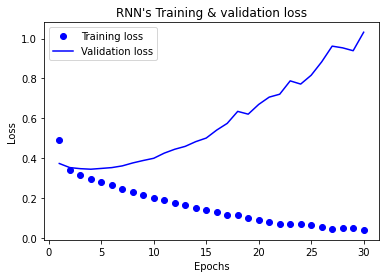

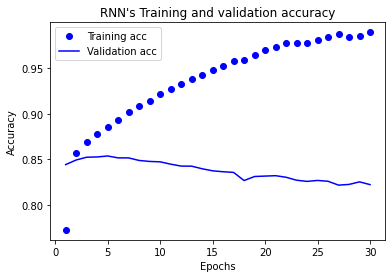

In [33]:
# 평가하기
results_rnn = model_rnn.evaluate(X_test, y_test, verbose=2)
print(results_rnn)

history_dict_rnn = history_rnn.history
print(history_dict_rnn.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# train과 val의 Loss
acc_rnn = history_dict_rnn['accuracy']
val_acc_rnn = history_dict_rnn['val_accuracy']
loss_rnn = history_dict_rnn['loss']
val_loss_rnn = history_dict_rnn['val_loss']

epochs_rnn = range(1, len(acc_rnn) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs_rnn, loss_rnn, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs_rnn, val_loss_rnn, 'b', label='Validation loss')
plt.title('RNN\'s Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# train과 val의 accuracy
plt.clf()  

plt.plot(epochs_rnn, acc_rnn, 'bo', label='Training acc')
plt.plot(epochs_rnn, val_acc_rnn, 'b', label='Validation acc')
plt.title('RNN\'s Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [34]:
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=naver_spm2 --vocab_size=1729'.format(temp_file)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l naver_spm2*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=naver_spm2 --vocab_size=1729
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: naver_spm2
  model_type: UNIGRAM
  vocab_size: 1729
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 258231 Nov  7 06:49 naver_spm2.model
-rw-r--r-- 1 root root  22022 Nov  7 06:49 naver_spm2.vocab


In [35]:
s_uni2 = spm.SentencePieceProcessor()
s_uni2.Load('naver_spm2.model') 

True

In [36]:
def sp_tokenize(s_uni2, corpus): 

    tensor = []

    for sen in corpus:
        tensor.append(s_uni2.EncodeAsIds(sen))

    with open("./naver_spm2.vocab", 'r') as f: 
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen = 100)

    return tensor, word_index, index_word

In [37]:
vocab_size = 1729
word_vector_dim = 100

model_rnn2 = keras.Sequential()
model_rnn2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn2.add(keras.layers.LSTM(12))   
model_rnn2.add(keras.layers.Dense(4, activation='relu'))
model_rnn2.add(keras.layers.Dense(1, activation='sigmoid'))  

model_rnn2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         172900    
_________________________________________________________________
lstm_1 (LSTM)                (None, 12)                5424      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 52        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 178,381
Trainable params: 178,381
Non-trainable params: 0
_________________________________________________________________


In [38]:
model_rnn2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
              
epochs = 30

history_rnn2 = model_rnn2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/30
188/188 [==============================] - 4s 12ms/step - loss: 0.5576 - accuracy: 0.7338 - val_loss: 0.4646 - val_accuracy: 0.7789
Epoch 2/30
188/188 [==============================] - 2s 9ms/step - loss: 0.4531 - accuracy: 0.7863 - val_loss: 0.4466 - val_accuracy: 0.7836
Epoch 3/30
188/188 [==============================] - 2s 9ms/step - loss: 0.4385 - accuracy: 0.7913 - val_loss: 0.4417 - val_accuracy: 0.7862
Epoch 4/30
188/188 [==============================] - 2s 9ms/step - loss: 0.4290 - accuracy: 0.7960 - val_loss: 0.4398 - val_accuracy: 0.7882
Epoch 5/30
188/188 [==============================] - 2s 9ms/step - loss: 0.4207 - accuracy: 0.7995 - val_loss: 0.4372 - val_accuracy: 0.7890
Epoch 6/30
188/188 [==============================] - 2s 9ms/step - loss: 0.4127 - accuracy: 0.8041 - val_loss: 0.4356 - val_accuracy: 0.7885
Epoch 7/30
188/188 [==============================] - 2s 9ms/step - loss: 0.4050 - accuracy: 0.8068 - val_loss: 0.4365 - val_accuracy: 0.7885
Epoch

In [39]:
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=naver_spm3 --vocab_size=4000'.format(temp_file)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l naver_spm3*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=naver_spm3 --vocab_size=4000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: naver_spm3
  model_type: UNIGRAM
  vocab_size: 4000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 298289 Nov  7 06:51 naver_spm3.model
-rw-r--r-- 1 root root  64169 Nov  7 06:51 naver_spm3.vocab


In [40]:
s_uni3 = spm.SentencePieceProcessor()
s_uni3.Load('naver_spm3.model') 

True

In [41]:
vocab_size = 4000
word_vector_dim = 100

model_rnn3 = keras.Sequential()
model_rnn3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn3.add(keras.layers.LSTM(12))   
model_rnn3.add(keras.layers.Dense(4, activation='relu'))
model_rnn3.add(keras.layers.Dense(1, activation='sigmoid'))  

model_rnn3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         400000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 12)                5424      
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 52        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 405,481
Trainable params: 405,481
Non-trainable params: 0
_________________________________________________________________


In [42]:
model_rnn3.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
              
epochs = 30

history_rnn3 = model_rnn3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/30
188/188 [==============================] - 4s 12ms/step - loss: 0.5502 - accuracy: 0.7349 - val_loss: 0.4166 - val_accuracy: 0.8182
Epoch 2/30
188/188 [==============================] - 2s 9ms/step - loss: 0.3863 - accuracy: 0.8304 - val_loss: 0.3822 - val_accuracy: 0.8278
Epoch 3/30
188/188 [==============================] - 2s 10ms/step - loss: 0.3548 - accuracy: 0.8443 - val_loss: 0.3770 - val_accuracy: 0.8286
Epoch 4/30
188/188 [==============================] - 2s 10ms/step - loss: 0.3375 - accuracy: 0.8521 - val_loss: 0.3761 - val_accuracy: 0.8313
Epoch 5/30
188/188 [==============================] - 2s 9ms/step - loss: 0.3236 - accuracy: 0.8588 - val_loss: 0.3795 - val_accuracy: 0.8287
Epoch 6/30
188/188 [==============================] - 2s 9ms/step - loss: 0.3113 - accuracy: 0.8638 - val_loss: 0.3850 - val_accuracy: 0.8287
Epoch 7/30
188/188 [==============================] - 2s 9ms/step - loss: 0.2989 - accuracy: 0.8690 - val_loss: 0.3900 - val_accuracy: 0.8295
Epo

In [43]:
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=naver_spm4 --vocab_size=6000'.format(temp_file)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l naver_spm4*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=naver_spm4 --vocab_size=6000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: naver_spm4
  model_type: UNIGRAM
  vocab_size: 6000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 336081 Nov  7 06:53 naver_spm4.model
-rw-r--r-- 1 root root 103693 Nov  7 06:53 naver_spm4.vocab


In [44]:
s_uni4 = spm.SentencePieceProcessor()
s_uni4.Load('naver_spm4.model') 

True

In [45]:
vocab_size = 4000
word_vector_dim = 100

model_rnn4 = keras.Sequential()
model_rnn4.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn4.add(keras.layers.LSTM(12))   
model_rnn4.add(keras.layers.Dense(4, activation='relu'))
model_rnn4.add(keras.layers.Dense(1, activation='sigmoid'))  

model_rnn4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         400000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 12)                5424      
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 52        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 405,481
Trainable params: 405,481
Non-trainable params: 0
_________________________________________________________________


In [46]:
model_rnn4.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
              
epochs = 30

history_rnn4 = model_rnn4.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/30
188/188 [==============================] - 4s 12ms/step - loss: 0.5245 - accuracy: 0.7622 - val_loss: 0.4050 - val_accuracy: 0.8222
Epoch 2/30
188/188 [==============================] - 2s 9ms/step - loss: 0.3840 - accuracy: 0.8327 - val_loss: 0.3860 - val_accuracy: 0.8271
Epoch 3/30
188/188 [==============================] - 2s 9ms/step - loss: 0.3597 - accuracy: 0.8442 - val_loss: 0.3800 - val_accuracy: 0.8307
Epoch 4/30
188/188 [==============================] - 2s 9ms/step - loss: 0.3431 - accuracy: 0.8513 - val_loss: 0.3828 - val_accuracy: 0.8296
Epoch 5/30
188/188 [==============================] - 2s 9ms/step - loss: 0.3297 - accuracy: 0.8580 - val_loss: 0.3884 - val_accuracy: 0.8264
Epoch 6/30
188/188 [==============================] - 2s 9ms/step - loss: 0.3181 - accuracy: 0.8628 - val_loss: 0.3895 - val_accuracy: 0.8268
Epoch 7/30
188/188 [==============================] - 2s 9ms/step - loss: 0.3067 - accuracy: 0.8679 - val_loss: 0.3927 - val_accuracy: 0.8254
Epoch

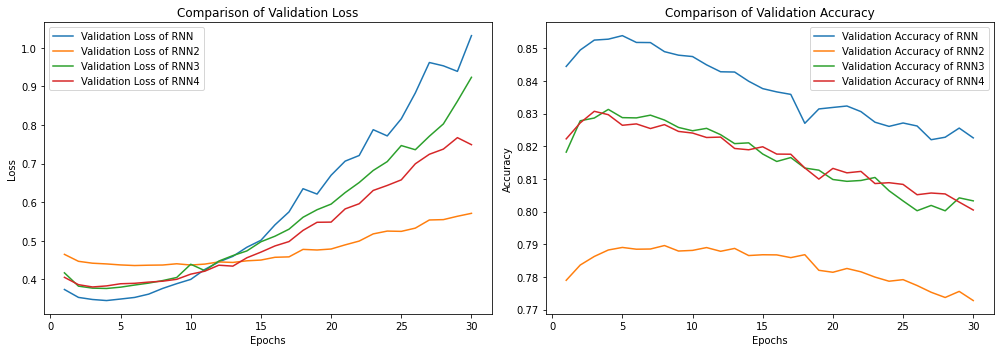

In [47]:
import matplotlib.pyplot as plt

# 각 모델의 히스토리 데이터를 담을 리스트
histories = [history_rnn.history, history_rnn2.history, history_rnn3.history, history_rnn4.history]

model_names = ['RNN', 'RNN2', 'RNN3', 'RNN4']

# 손실 그래프 그리기
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
for history, model_name in zip(histories, model_names):
    val_loss = history['val_loss']
    epochs = range(1, len(val_loss) + 1)
    plt.plot(epochs, val_loss, label=f'Validation Loss of {model_name}')
plt.title('Comparison of Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프 그리기
plt.subplot(1, 2, 2)
for history, model_name in zip(histories, model_names):
    val_acc = history['val_accuracy']
    epochs = range(1, len(val_acc) + 1)
    plt.plot(epochs, val_acc, label=f'Validation Accuracy of {model_name}')
plt.title('Comparison of Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [48]:
# Validation Loss, Accuracy를 보면 4~5 Epochs 정도가 최적인 것 같고
# 단어 수는 10000 이상은 하지 않았지만 다다익선의 경향을 보이나 4000이나 6000이나 크게 차이가 없음